[*********************100%***********************]  1 of 1 completed
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Série carregada: 2018-01-01 00:00:00 → 2024-12-31 00:00:00 | pontos: 2557
Tamanhos → train: 2045 | test: 512
                      MAE       RMSE  MAPE(%)
Modelo                                       
Naive            1089.415   1621.973    1.843
SNaive(7)        2998.979   4187.736    5.140
ARIMA(1, 1, 1)  27945.043  33712.615   42.885


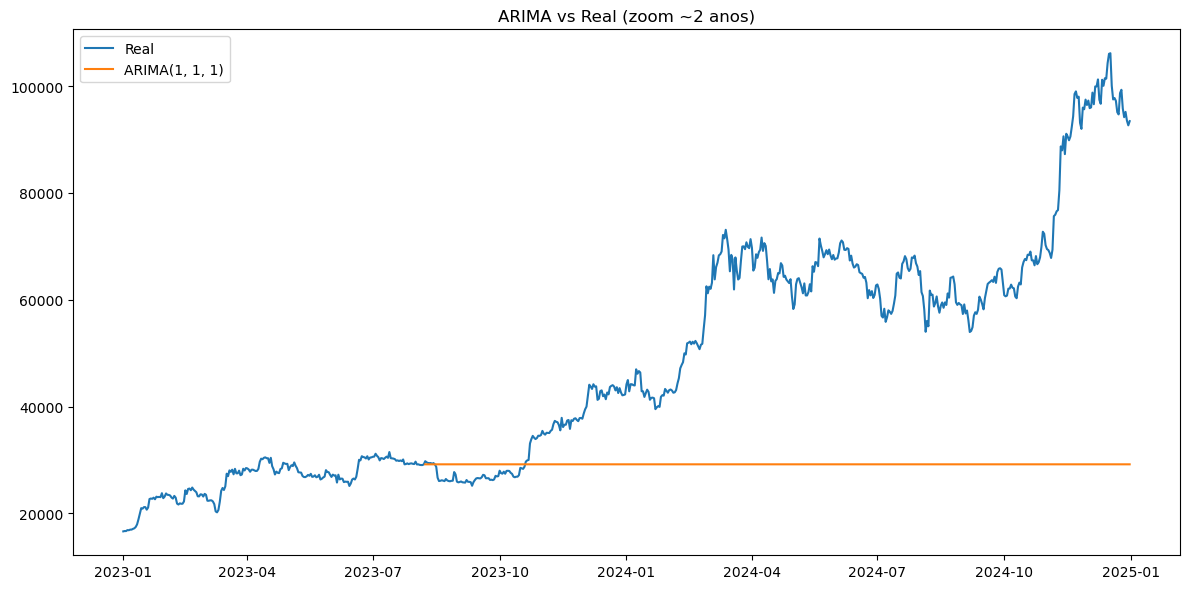

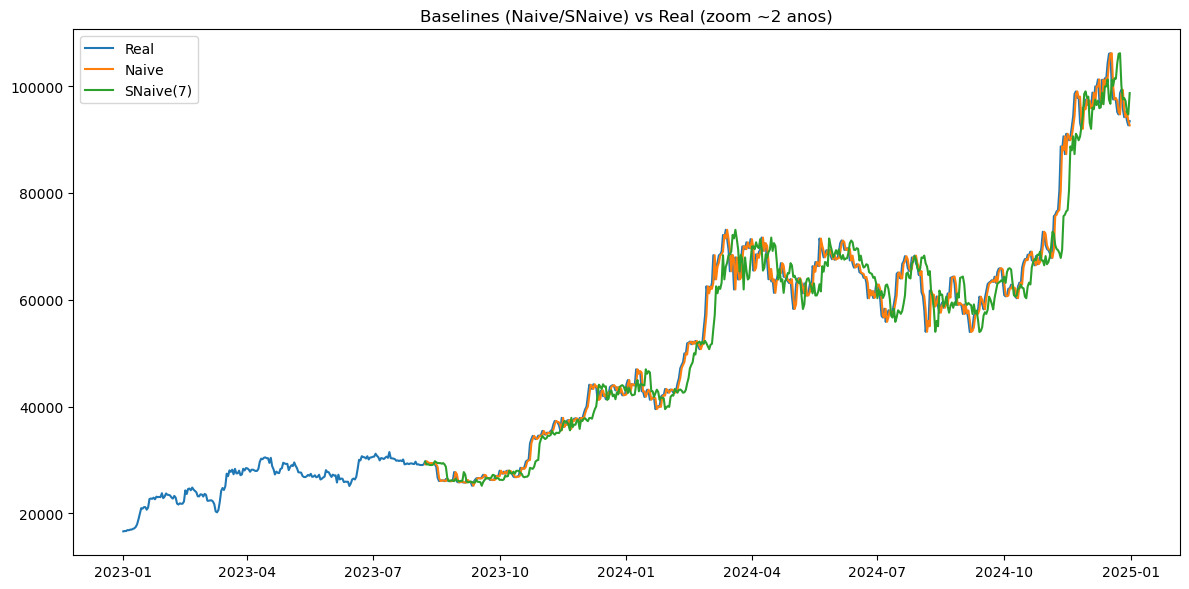

Arquivos salvos:
- resultados_semana4_metrics.csv
- predicoes_semana4.csv
- plot_semana4_arima_vs_real.png
- plot_semana4_baselines_vs_real.png


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # manter a saída limpa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf

# ===== 1) Carregar dados (CSV limpo seu, se existir; senão baixa do yfinance) =====
caminho_csv = Path('btc_clean.csv')  # ajuste se o seu arquivo tiver outro nome

if caminho_csv.exists():
    df = pd.read_csv(caminho_csv, parse_dates=['Date'])
    if 'Date' in df.columns:
        df = df.set_index('Date')
    # tentar detectar a coluna de fechamento
    possiveis = [c for c in df.columns if c.lower() in ('close','fechamento')]
    close_col = possiveis[0] if possiveis else df.columns[0]
    s = pd.to_numeric(df[close_col], errors='coerce').dropna()
else:
    btc = yf.download('BTC-USD', start='2018-01-01', end='2025-01-01')
    # resolver MultiIndex se vier empilhado
    if isinstance(btc.columns, pd.MultiIndex):
        btc.columns = [a if b == '' else a for (a,b) in btc.columns]
    s = pd.to_numeric(btc['Close'], errors='coerce').dropna()

# garantir índice datetime e frequência diária (sem obrigar reamostragem dura)
s.index = pd.to_datetime(s.index)
s = s.sort_index()
print('Série carregada:', s.index.min(), '→', s.index.max(), '| pontos:', len(s))

# ===== 2) Split treino/teste =====
# 80/20 por simplicidade; mantenha consistente nas outras comparações
split = int(len(s) * 0.8)
train = s.iloc[:split].copy()
test  = s.iloc[split:].copy()
print('Tamanhos → train:', len(train), '| test:', len(test))

# ===== 3) Funções de métrica (evita problema do sklearn "squared") =====
def mae(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    dfm = pd.concat([y_true, y_pred], axis=1).dropna()
    return (dfm.iloc[:,0] - dfm.iloc[:,1]).abs().mean()

def rmse(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    dfm = pd.concat([y_true, y_pred], axis=1).dropna()
    return np.sqrt(((dfm.iloc[:,0] - dfm.iloc[:,1])**2).mean())

def mape(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    dfm = pd.concat([y_true, y_pred], axis=1).dropna()
    # evita divisão por zero
    dfm = dfm[dfm.iloc[:,0] != 0]
    return (dfm.iloc[:,0].sub(dfm.iloc[:,1]).abs().div(dfm.iloc[:,0]).mean()) * 100

# ===== 4) Baselines: Naive e SNaive(7) =====
# usar a série completa para que o shift encontre valores de referência no início do teste
s_all = s.copy()

pred_naive   = s_all.shift(1).loc[test.index]     # valor de ontem
pred_snaive7 = s_all.shift(7).loc[test.index]     # valor da semana passada

# ===== 5) ARIMA (fit 1x no treino, forecast no horizonte de teste) =====
# ordem inicial simples; depois você ajusta via AIC/ACF/PACF
order = (1,1,1)
model = ARIMA(train, order=order)
res = model.fit()
pred_arima = res.forecast(steps=len(test))
pred_arima.index = test.index  # alinhar índices

# ===== 6) Métricas =====
linhas = []
for nome, yhat in [('Naive', pred_naive),
                   ('SNaive(7)', pred_snaive7),
                   (f'ARIMA{order}', pred_arima)]:
    linhas.append({
        'Modelo': nome,
        'MAE': mae(test, yhat),
        'RMSE': rmse(test, yhat),
        'MAPE(%)': mape(test, yhat)
    })

df_metrics = pd.DataFrame(linhas).set_index('Modelo').sort_values('MAPE(%)')
print(df_metrics.round(3))

# salvar métricas
df_metrics.round(6).to_csv('resultados_semana4_metrics.csv', index=True)

# ===== 7) Salvar previsões (para reuso no relatório) =====
df_preds = pd.DataFrame({
    'Real': test,
    'Naive': pred_naive,
    'SNaive7': pred_snaive7,
    f'ARIMA{order}': pred_arima
})
df_preds.to_csv('predicoes_semana4.csv', index=True)

# ===== 8) Gráficos (zoom 2 anos) =====
def plot_zoom(series_dict, titulo, fname, dias=730):
    # pega janela final
    idx_max = s.index.max()
    corte = idx_max - pd.Timedelta(days=dias)
    plt.figure(figsize=(12,6))
    for rot, serie in series_dict.items():
        serie_plot = serie[serie.index >= corte]
        plt.plot(serie_plot.index, serie_plot.values, label=rot)
    plt.title(titulo)
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.show()

# 8.1) ARIMA vs Real
plot_zoom(
    {'Real': s, f'ARIMA{order}': pred_arima.reindex(s.index)},  # reindex só para plot conjunto
    'ARIMA vs Real (zoom ~2 anos)',
    'plot_semana4_arima_vs_real.png',
    dias=730
)

# 8.2) Baselines vs Real
# reindex para alinhamento visual; os períodos sem previsão aparecerão como lacunas
plot_zoom(
    {'Real': s, 'Naive': pred_naive.reindex(s.index), 'SNaive(7)': pred_snaive7.reindex(s.index)},
    'Baselines (Naive/SNaive) vs Real (zoom ~2 anos)',
    'plot_semana4_baselines_vs_real.png',
    dias=730
)

print('Arquivos salvos:')
print('- resultados_semana4_metrics.csv')
print('- predicoes_semana4.csv')
print('- plot_semana4_arima_vs_real.png')
print('- plot_semana4_baselines_vs_real.png')
